## Машинное обучение в бизнесе
### Урок 4. Uplift-моделирование

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from IPython.display import Image

from catboost import CatBoostClassifier
import warnings


In [47]:
df = pd.read_csv('./HW_data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [48]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [49]:
df['treatment'] = df['treatment'].map({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [51]:
indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=123)
indices_learn, indices_valid

(Int64Index([53181, 42635,  6296, 41722, 32660, 14730, 40469, 49818, 51773,
             34850,
             ...
             63594,  7763, 15377, 63206, 54370, 61404, 17730, 28030, 15725,
             52734],
            dtype='int64', length=44800),
 Int64Index([19593,  4997, 36682, 29881, 25401, 41888,  4353, 33487, 63951,
             35285,
             ...
             41382, 46836, 36489, 13683, 10904, 39655, 45479, 21007, 39923,
             61435],
            dtype='int64', length=19200))

In [52]:
train_features = df.copy().drop(['target', 'treatment'], axis=1)
train_features

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web
3,9,675.83,1,0,Rural,1,Web
4,2,45.34,1,0,Urban,0,Web
...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web
63996,5,38.91,0,1,Urban,1,Phone
63997,6,29.99,1,0,Urban,1,Phone
63998,1,552.94,1,0,Surburban,1,Multichannel


In [53]:
X_train = train_features.loc[indices_learn, :]
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']
X_test = train_features.loc[indices_valid, :]
y_test = df.loc[indices_valid, 'target']
treat_test =  df.loc[indices_valid, 'treatment']
X_train_full = train_features.loc[df.index, :]
y_train_full = df.loc[:, 'target']
treat_train_full = df.loc[:, 'treatment']

In [54]:
df['zip_code'].unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [55]:
df['zip_code'] = df['zip_code'].map({'Surburban': 1, 'Rural': 2, 'Urban': 3})
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,1,0,Phone,1,0
1,6,329.08,1,1,2,1,Web,0,0
2,7,180.65,0,1,1,1,Web,1,0
3,9,675.83,1,0,2,1,Web,1,0
4,2,45.34,1,0,3,0,Web,1,0


In [56]:
df['channel'].unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [57]:
df['channel'] = df['channel'].map({'Phone': 1, 'Web': 2, 'Multichannel': 3})
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,1,0,1,1,0
1,6,329.08,1,1,2,1,2,0,0
2,7,180.65,0,1,1,1,2,1,0
3,9,675.83,1,0,2,1,2,1,0
4,2,45.34,1,0,3,0,2,1,0


In [58]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

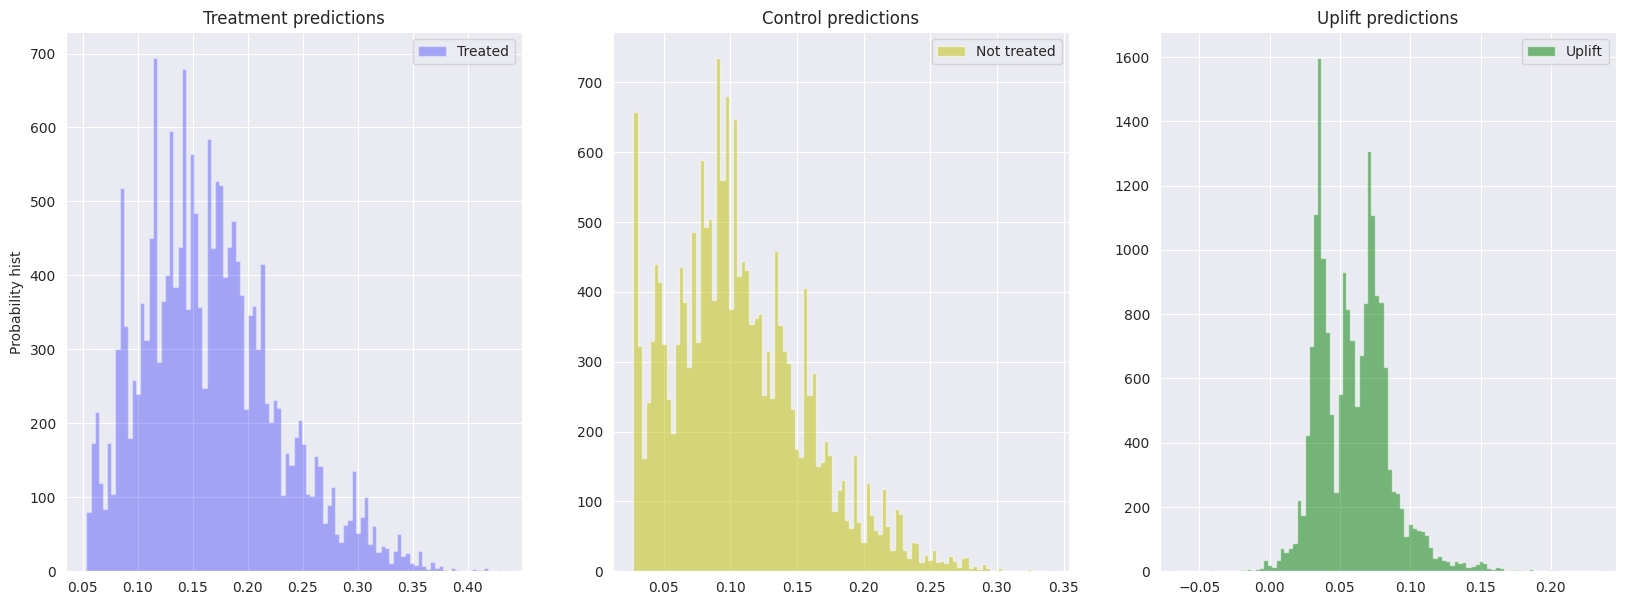

In [59]:
cat_features = ['zip_code', 'channel']

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

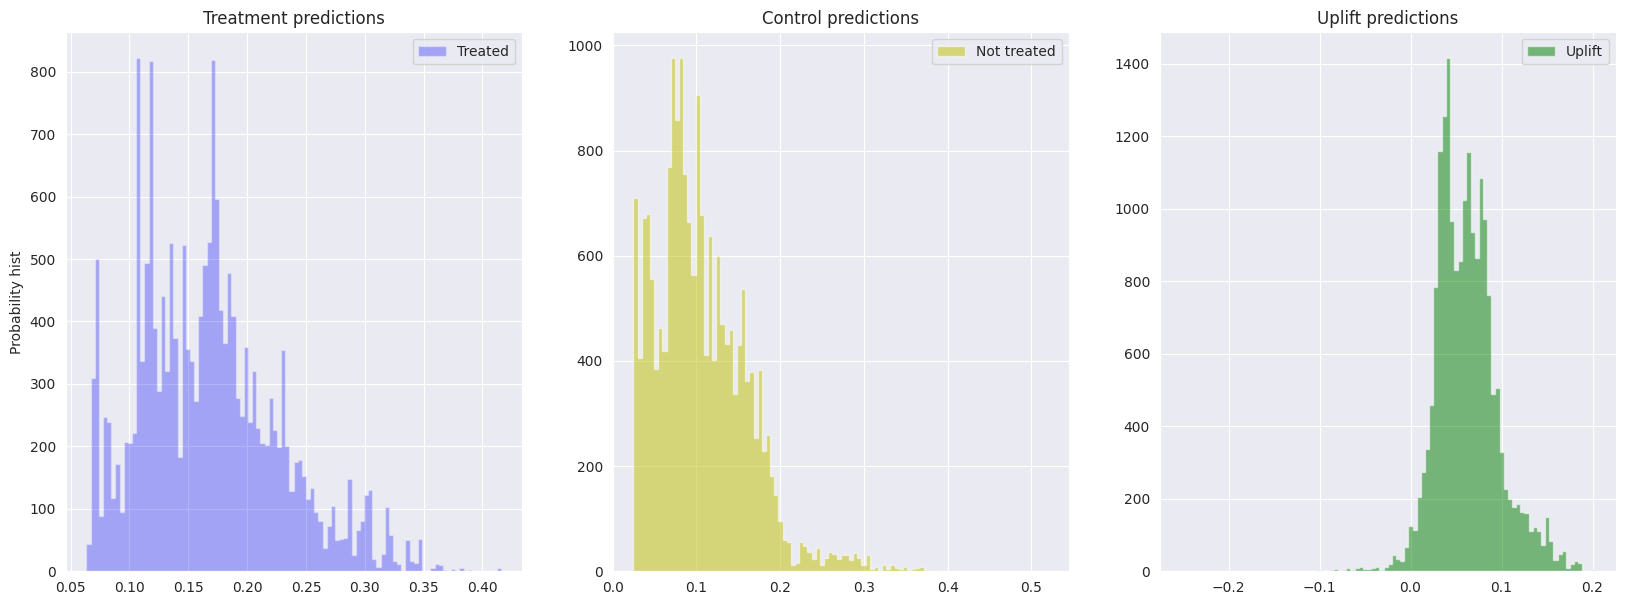

In [60]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features},
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [61]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.117411,0.095800
0,SoloModel,0.089254,0.078994
2,TwoModels,0.078306,0.068439
